In [1]:
## uncomment if xgboost is not installed
# !pip install xgboost

## uncomment if evidently is not installed; for creating model card
# !pip install evidently

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn

In [3]:
from evidently.dashboard import Dashboard
from evidently.tabs import DataDriftTab, CatTargetDriftTab

from evidently.model_profile import Profile
from evidently.profile_sections import DataDriftProfileSection

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
train_df = pd.read_parquet("../data/interim/train.parquet")
test_df = pd.read_parquet("../data/interim/test.parquet")
production_df = pd.read_parquet("../data/interim/production.parquet")

In [6]:
X_train = train_df.drop("satisfaction",axis=1).copy()
X_test = test_df.drop("satisfaction",axis=1).copy()
X_production = production_df.drop("satisfaction",axis=1).copy()

In [7]:
y_train = train_df["satisfaction"].copy()
y_test = test_df["satisfaction"].copy()
y_production = production_df["satisfaction"].copy()

In [8]:
numerical_features = [x for x in X_train.select_dtypes(exclude = np.object)]
categorical_features = [x for x in X_train.select_dtypes(include = np.object)]

In [9]:
x_columns = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Seat comfort', 'Departure_Arrival time convenient',
       'Food and drink', 'Gate location', 'Inflight wifi service',
       'Inflight entertainment', 'Online support', 'Ease of Online booking',
       'Onboard service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [10]:
X_train.head()

Gender   Customer Type  Age   Type of Travel     Class  Flight Distance  \
98180   Male  Loyal Customer   37  Business travel  Business             3785   
24974   Male  Loyal Customer   60  Personal Travel       Eco             1784   
69242   Male  Loyal Customer   27  Business travel  Business             1825   
90488   Male  Loyal Customer   50  Business travel       Eco             2024   
36205   Male  Loyal Customer   70  Personal Travel       Eco             1435   

       Seat comfort  Departure_Arrival time convenient  Food and drink  \
98180             4                                  4               4   
24974             3                                  4               3   
69242             2                                  3               4   
90488             4                                  4               2   
36205             4                                  4               4   

       Gate location  ...  Online support  Ease of Online booking  \
98180              4  ...               4                       4   
24974              1  ...               2                       5   
69242              3  ...               2                       2   
90488              2  ...               4                       4   
36205              5  ...               5                       5   

       Onboard service  Leg room service  Baggage handling  Checkin service  \
98180                4                 4                 4                5   
24974                3                 2                 4                4   
69242                1                 3                 3                1   
90488                2                 5                 4                2   
36205                5                 4                 5                4   

       Cleanliness  Online boarding  Departure Delay in Minutes  \
98180            4                4                           1   
24974            4                5                           0   
69242            2                2                          76   
90488            4                4                         125   
36205            4                5                           0   

       Arrival Delay in Minutes  
98180                       9.0  
24974                       0.0  
69242                      57.0  
90488                     129.0  
36205                       0.0  

[5 rows x 22 columns]

In [11]:
production_df = production_df.reset_index()
train_df = train_df.reset_index()

# Creating pipeline

In [12]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

ohe_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[        
        ('num', numeric_transformer, numerical_features),
        ('cat', ohe_encoder, categorical_features)])

xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=20,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=42)


xg_v1 = Pipeline(steps=[('preprocessor', preprocessor),
                          ('xbg1', xgb1)])       

xg_v1.fit(X_train, y_train)


#rmse = np.sqrt(mean_squared_error(y_test, 
#                                  reg.predict(X_test)))

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:33:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight Distance',
                                                   'Seat comfort',
                                                   'Departure_Arrival time '
                                                   'convenient',
                                                   'Food and drink',
                                                   'Gate location',
                                                   'Inflight wifi service',
                                                   'Inflight entertainment',
                                                   'Online support',
                                                   'Ease of Online booking',
                       

## Prediction with the production data

In [13]:
production_df['prediction'] = xg_v1.predict(production_df[x_columns])

## Retriving dummy variables from the pipeline

In [14]:
new_cat_features = list(xg_v1['preprocessor'].transformers_[1][1].get_feature_names())

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
new_cat_features

['x0_Female',
 'x0_Male',
 'x1_Loyal Customer',
 'x1_disloyal Customer',
 'x2_Business travel',
 'x2_Personal Travel',
 'x3_Business',
 'x3_Eco',
 'x3_Eco Plus']

In [16]:
len(numerical_features + new_cat_features)

27

## Preparing production data

In [17]:
prod_df_x_cols = xg_v1.named_steps['preprocessor'].transform(production_df[x_columns])
prod_df_x_cols_df = pd.DataFrame( prod_df_x_cols, columns  = numerical_features + new_cat_features)
prod_df_x_cols_df_final = pd.concat([X_production[numerical_features].reset_index(), prod_df_x_cols_df[new_cat_features]], axis=1)
prod_df_x_cols_df_final['prediction'] = xg_v1.predict(production_df[x_columns])
# prod_df_x_cols_df_final['Actual'] = np.array(y_production)
prod_df_x_cols_df_final

index  Age  Flight Distance  Seat comfort  \
0       70145   54              872             5   
1      123986   41             4867             1   
2       92927   27             4022             4   
3       56177   25             2382             3   
4       18922   38             2201             5   
...       ...  ...              ...           ...   
12944  128496   56              901             5   
12945  104012   57              884             1   
12946     865   44             2376             0   
12947   15862   12             3221             4   
12948  122328   30             2289             3   

       Departure_Arrival time convenient  Food and drink  Gate location  \
0                                      2               5              5   
1                                      1               1              1   
2                                      2               2              2   
3                                      4               4              3   
4                                      2               5              5   
...                                  ...             ...            ...   
12944                                  5               5              5   
12945                                  1               1              1   
12946                                  2               0              3   
12947                                  5               5              5   
12948                                  3               3              3   

       Inflight wifi service  Inflight entertainment  Online support  ...  \
0                          3                       4               5  ...   
1                          5                       5               5  ...   
2                          4                       4               4  ...   
3                          5                       4               4  ...   
4                          4                       5               4  ...   
...                      ...                     ...             ...  ...   
12944                      5                       4               4  ...   
12945                      4                       5               4  ...   
12946                      3                       3               3  ...   
12947                      4                       4               5  ...   
12948                      5                       5               5  ...   

       x0_Female  x0_Male  x1_Loyal Customer  x1_disloyal Customer  \
0            0.0      1.0                1.0                   0.0   
1            1.0      0.0                1.0                   0.0   
2            1.0      0.0                1.0                   0.0   
3            1.0      0.0                0.0                   1.0   
4            1.0      0.0                1.0                   0.0   
...          ...      ...                ...                   ...   
12944        1.0      0.0                1.0                   0.0   
12945        0.0      1.0                1.0                   0.0   
12946        1.0      0.0                1.0                   0.0   
12947        1.0      0.0                1.0                   0.0   
12948        0.0      1.0                1.0                   0.0   

       x2_Business travel  x2_Personal Travel  x3_Business  x3_Eco  \
0                     1.0                 0.0          1.0     0.0   
1                     1.0                 0.0          1.0     0.0   
2                     1.0                 0.0          1.0     0.0   
3                     1.0                 0.0          0.0     1.0   
4                     0.0                 1.0          0.0     1.0   
...                   ...                 ...          ...     ...   
12944                 1.0                 0.0          1.0     0.0   
12945                 1.0                 0.0          1.0     0.0   
12946                 0.0                 1.0          0.0     1.0   
1294

## Preparing the training data

In [18]:
x_train_new = X_train
x_train_x_cols = xg_v1.named_steps['preprocessor'].transform(x_train_new)
x_train_x_cols_df = pd.DataFrame( x_train_x_cols, columns  = numerical_features + new_cat_features)
x_train_x_cols_df_final = pd.concat([x_train_new[numerical_features].reset_index(), x_train_x_cols_df[new_cat_features]], axis = 1)
x_train_x_cols_df_final['prediction'] = xg_v1.predict(X_train)
x_train_x_cols_df_final['Actual'] = np.array(y_train)
x_train_x_cols_df_final

index  Age  Flight Distance  Seat comfort  \
0       98180   37             3785             4   
1       24974   60             1784             3   
2       69242   27             1825             2   
3       90488   50             2024             4   
4       36205   70             1435             4   
...       ...  ...              ...           ...   
77687   54077   28             1589             3   
77688  113068   33              224             5   
77689    1425   62             3375             1   
77690   77485   39             1421             4   
77691   14770    8             2738             2   

       Departure_Arrival time convenient  Food and drink  Gate location  \
0                                      4               4              4   
1                                      4               3              1   
2                                      3               4              3   
3                                      4               2              2   
4                                      4               4              5   
...                                  ...             ...            ...   
77687                                  3               3              3   
77688                                  5               5              5   
77689                                  1               1              4   
77690                                  4               4              4   
77691                                  4               2              4   

       Inflight wifi service  Inflight entertainment  Online support  ...  \
0                          4                       5               4  ...   
1                          5                       3               2  ...   
2                          2                       1               2  ...   
3                          4                       4               4  ...   
4                          5                       4               5  ...   
...                      ...                     ...             ...  ...   
77687                      1                       3               1  ...   
77688                      4                       5               5  ...   
77689                      1                       1               1  ...   
77690                      2                       4               4  ...   
77691                      4                       2               4  ...   

       x0_Male  x1_Loyal Customer  x1_disloyal Customer  x2_Business travel  \
0          1.0                1.0                   0.0                 1.0   
1          1.0                1.0                   0.0                 0.0   
2          1.0                1.0                   0.0                 1.0   
3          1.0                1.0                   0.0                 1.0   
4          1.0                1.0                   0.0                 0.0   
...        ...                ...                   ...                 ...   
77687      0.0                0.0                   1.0                 1.0   
77688      0.0                1.0                   0.0                 1.0   
77689      1.0                1.0                   0.0                 0.0   
77690      1.0                1.0                   0.0                 1.0   
77691      1.0                1.0                   0.0                 0.0   

       x2_Personal Travel  x3_Business  x3_Eco  x3_Eco Plus    prediction  \
0                     0.0          1.0     0.0          0.0     satisfied   
1                     1.0          0.0     1.0          0.0  dissatisfied   
2                     0.0          1.0     0.0          0.0  dissatisfied   
3                     0.0          0.0     1.0          0.0     satisfied   
4                     1.0          0.0     1.0          0.0  dissatisfied   
...                   ...          ...     ...          ...           ...   
77687                 0.0          1.0     0.0          0

# Local explanation using LIME - Local Interpretation of Model Explanation

In [4]:
!pip install lime

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=42e7c6d9a13f919f60f044f4f5353d566c503f8d68e3d71b02ad0905ca15eb14
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\e6\a6\20\cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [25]:
import lime
import lime.lime_tabular

In [26]:
X_train_encoded_df = pd.get_dummies( X_train,
                                 columns = categorical_features,
                                 drop_first = True ) 

In [27]:
X_features = list( X_train_encoded_df.columns )

In [28]:
explainer = (lime
             .lime_tabular
             .LimeTabularExplainer(training_data = X_train_encoded_df.to_numpy(), 
                                   training_labels = y_train,                                   
                                   feature_names = X_features, 
                                   class_names = ['dissatisfied', 'satisfied'],
                                   categorical_features = categorical_features,
                                   #categorical_names = ['famhist_Present'], 
                                   kernel_width=3,
                                   verbose = True ))

## Explaining a case of dissatisfied customer

In [29]:
X_test_encoded_df = pd.get_dummies( X_test,
                                 columns = categorical_features,
                                 drop_first = True ) 

In [30]:
X_test_encoded_df.iloc[0]

Age                                    69.0
Flight Distance                      1337.0
Seat comfort                            1.0
Departure_Arrival time convenient       4.0
Food and drink                          1.0
Gate location                           1.0
Inflight wifi service                   4.0
Inflight entertainment                  1.0
Online support                          4.0
Ease of Online booking                  4.0
Onboard service                         3.0
Leg room service                        3.0
Baggage handling                        5.0
Checkin service                         3.0
Cleanliness                             5.0
Online boarding                         4.0
Departure Delay in Minutes              0.0
Arrival Delay in Minutes                0.0
Gender_Male                             1.0
Customer Type_disloyal Customer         0.0
Type of Travel_Personal Travel          1.0
Class_Eco                               1.0
Class_Eco Plus                  

In [31]:
xg_lime = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=20,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=42)

xg_lime.fit(X_train_encoded_df, y_train)

C:\Users\ADMIN\.conda\envs\mlopslab\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:36:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [32]:
exp = explainer.explain_instance( X_test_encoded_df.iloc[0].to_numpy(), 
                                  xg_lime.predict_proba )

Intercept 0.4210385278964783
Prediction_local [0.46823726]
Right: 0.00014262402


In [33]:
exp.show_in_notebook(show_table=True, show_all=False)

## Explaining a case of satisfied customer

In [34]:
exp = explainer.explain_instance( X_test_encoded_df.iloc[1].to_numpy(), # iloc[1] here is a satisfied customer
                                  xg_lime.predict_proba )

Intercept 0.06557149725182088
Prediction_local [0.82923352]
Right: 0.9999794


In [35]:
exp.show_in_notebook(show_table=True, show_all=False)

# Local explanation using SHAP - Shapley values

In [5]:
!pip install shap

In [36]:
import shap

## Explaining a case of dissatisfied customer

In [37]:
row_to_show = 0
data_for_prediction = X_test_encoded_df.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
xg_lime.predict_proba(data_for_prediction_array)

array([[9.9985737e-01, 1.4262402e-04]], dtype=float32)

In [38]:
explainer = shap.TreeExplainer(xg_lime)

shap_values = explainer.shap_values(data_for_prediction_array)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [39]:
shap.initjs()
shap.force_plot( explainer.expected_value, 
                 shap_values, 
                 data_for_prediction,
                 figsize=(20, 2) )

## Explaining a case of satisfied customer

In [40]:
row_to_show = 1
data_for_prediction = X_test_encoded_df.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
xg_lime.predict_proba(data_for_prediction_array)

shap_values = explainer.shap_values(data_for_prediction_array)

shap.initjs()
shap.force_plot( explainer.expected_value, 
                 shap_values, 
                 data_for_prediction,
                 figsize=(20, 2) )

array([[2.0623207e-05, 9.9997938e-01]], dtype=float32)

# Global interpretation

## Partial Dependence Plots

In [41]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

## Effect of Infilght entertainment on satisfaction

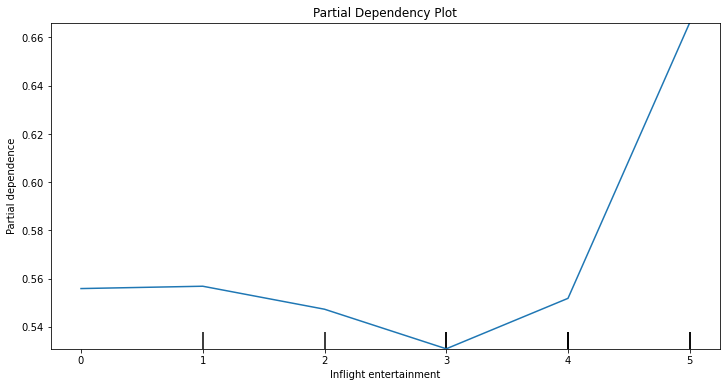

In [42]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(xg_v1,
                                        X_test,
                                        features = ['Inflight entertainment'],
                                        feature_names = x_columns,
                                        ax = ax);

## Effect of Cleanliness 

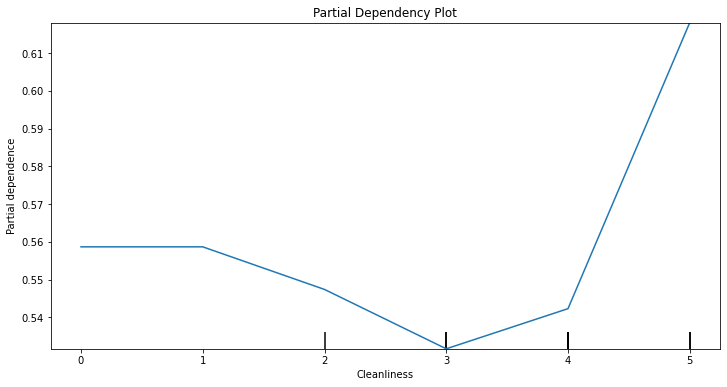

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial Dependency Plot")
PartialDependenceDisplay.from_estimator(xg_v1,
                                        X_test,
                                        features = ['Cleanliness'],
                                        feature_names = x_columns,
                                        ax = ax);

## Individual condition expectation

Text(0.5, 1.0, 'Individual Conditional Expectations')

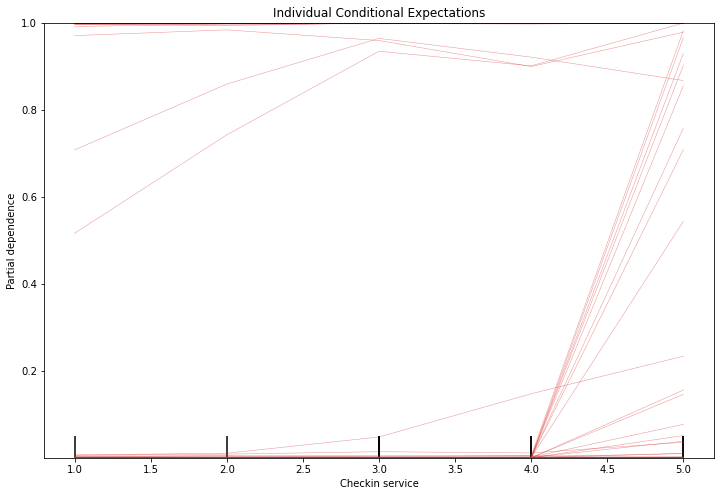

In [44]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Individual Conditional Expectations")

display = PartialDependenceDisplay.from_estimator(
    xg_v1,
    X_train,
    features=["Checkin service"],
    kind="individual",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:red", "alpha": 0.5, "linewidth": 0.5},
    ax = ax
)

Text(0.5, 1.0, 'Individual Conditional Expectations')

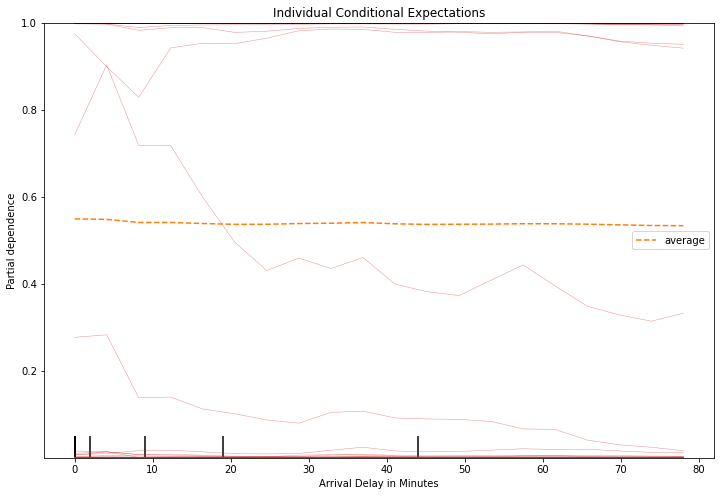

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Individual Conditional Expectations")

display = PartialDependenceDisplay.from_estimator(
    xg_v1,
    X_train,
    features=["Arrival Delay in Minutes"],
    kind="both",
    subsample=100,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:red", "alpha": 0.5, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
    ax = ax
)

# Understanding bias in model

In [46]:
y_production

70145        satisfied
123986       satisfied
92927     dissatisfied
56177     dissatisfied
18922        satisfied
              ...     
128496       satisfied
104012       satisfied
865          satisfied
15862        satisfied
122328       satisfied
Name: satisfaction, Length: 12949, dtype: object

<Figure size 216x288 with 0 Axes>

(array([2769.,    0., 3554.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

Text(0.5, 1.0, 'Male-Production_Data')

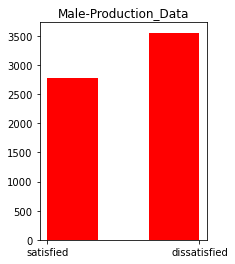

In [50]:
plt.figure(figsize=(3,4))
plt.hist(y_production[X_production.Gender=="Male"], color='r', bins=3)
plt.title("Male-Production_Data")

<Figure size 216x288 with 0 Axes>

(array([4322.,    0., 2304.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

Text(0.5, 1.0, 'Female-Production_Data')

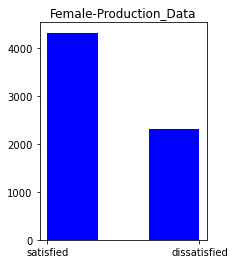

In [51]:
plt.figure(figsize=(3,4))
plt.hist(y_production[X_production.Gender=="Female"], color='b', bins=3)
plt.title("Female-Production_Data")

In [52]:
X_production

Gender      Customer Type  Age   Type of Travel     Class  \
70145     Male     Loyal Customer   54  Business travel  Business   
123986  Female     Loyal Customer   41  Business travel  Business   
92927   Female     Loyal Customer   27  Business travel  Business   
56177   Female  disloyal Customer   25  Business travel       Eco   
18922   Female     Loyal Customer   38  Personal Travel       Eco   
...        ...                ...  ...              ...       ...   
128496  Female     Loyal Customer   56  Business travel  Business   
104012    Male     Loyal Customer   57  Business travel  Business   
865     Female     Loyal Customer   44  Personal Travel       Eco   
15862   Female     Loyal Customer   12  Personal Travel       Eco   
122328    Male     Loyal Customer   30  Business travel  Business   

        Flight Distance  Seat comfort  Departure_Arrival time convenient  \
70145               872             5                                  2   
123986             4867             1                                  1   
92927              4022             4                                  2   
56177              2382             3                                  4   
18922              2201             5                                  2   
...                 ...           ...                                ...   
128496              901             5                                  5   
104012              884             1                                  1   
865                2376             0                                  2   
15862              3221             4                                  5   
122328             2289             3                                  3   

        Food and drink  Gate location  ...  Online support  \
70145                5              5  ...               5   
123986               1              1  ...               5   
92927                2              2  ...               4   
56177                4              3  ...               4   
18922                5              5  ...               4   
...                ...            ...  ...             ...   
128496               5              5  ...               4   
104012               1              1  ...               4   
865                  0              3  ...               3   
15862                5              5  ...               5   
122328               3              3  ...               5   

        Ease of Online booking  Onboard service  Leg room service  \
70145                        1                1                 2   
123986                       3                5                 5   
92927                        3                2                 3   
56177                        5                2                 4   
18922                        4                4                 4   
...                        ...              ...               ...   
128496                       5                5                 5   
104012                       4                4                 4   
865                          4                4                 0   
15862                        4                4                 4   
122328                       5                3                 4   

        Baggage handling  Checkin service  Cleanliness  Online boarding  \
70145                  1                4            1                5   
123986                 4                5            4                5   
92927                  2                4            3                4   
56177                  1                3            1                5   
18922                  5                4            4                4   
...                  ...              ...          ...              ...   
128496                 5                4            5                3   
104012                 4                5            4                3   
865              

In [53]:
prod_df_x_cols_df_final.set_index('index',inplace=True)

In [54]:
df = prod_df_x_cols_df_final.merge(y_production, how='inner', left_index=True, right_index=True)

In [55]:
df

Age  Flight Distance  Seat comfort  Departure_Arrival time convenient  \
70145    54              872             5                                  2   
123986   41             4867             1                                  1   
92927    27             4022             4                                  2   
56177    25             2382             3                                  4   
18922    38             2201             5                                  2   
...     ...              ...           ...                                ...   
128496   56              901             5                                  5   
104012   57              884             1                                  1   
865      44             2376             0                                  2   
15862    12             3221             4                                  5   
122328   30             2289             3                                  3   

        Food and drink  Gate location  Inflight wifi service  \
70145                5              5                      3   
123986               1              1                      5   
92927                2              2                      4   
56177                4              3                      5   
18922                5              5                      4   
...                ...            ...                    ...   
128496               5              5                      5   
104012               1              1                      4   
865                  0              3                      3   
15862                5              5                      4   
122328               3              3                      5   

        Inflight entertainment  Online support  Ease of Online booking  ...  \
70145                        4               5                       1  ...   
123986                       5               5                       3  ...   
92927                        4               4                       3  ...   
56177                        4               4                       5  ...   
18922                        5               4                       4  ...   
...                        ...             ...                     ...  ...   
128496                       4               4                       5  ...   
104012                       5               4                       4  ...   
865                          3               3                       4  ...   
15862                        4               5                       4  ...   
122328                       5               5                       5  ...   

        x0_Male  x1_Loyal Customer  x1_disloyal Customer  x2_Business travel  \
70145       1.0                1.0                   0.0                 1.0   
123986      0.0                1.0                   0.0                 1.0   
92927       0.0                1.0                   0.0                 1.0   
56177       0.0                0.0                   1.0                 1.0   
18922       0.0                1.0                   0.0                 0.0   
...         ...                ...                   ...                 ...   
128496      0.0                1.0                   0.0                 1.0   
104012      1.0                1.0                   0.0                 1.0   
865         0.0                1.0                   0.0                 0.0   
15862       0.0                1.0                   0.0                 0.0   
122328      1.0                1.0                   0.0                 1.0   

        x2_Personal Travel  x3_Business  x3_Eco  x3_Eco Plus    prediction  \
70145                  0.0          1.0     0.0          0.0     satisfied   
123986                 0.0          1.0     0.0          0.0     satisfied   
92927                  0.0          1.0     0.0          0.0  dissatisfied   
56177                  0.0          0.0     

In [56]:
df.prediction.value_counts()

satisfied       6978
dissatisfied    5971
Name: prediction, dtype: int64

In [57]:
df.satisfaction.value_counts()

satisfied       7091
dissatisfied    5858
Name: satisfaction, dtype: int64

<Figure size 216x288 with 0 Axes>

Text(0.5, 1.0, 'Male-Production_Data')

Text(0.0, 2769.0, '2769.0')

Text(0.6666666666666666, 3554.0, '3554.0')

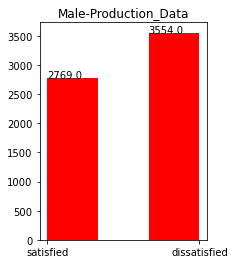

In [58]:
plt.figure(figsize=(3,4))
h1 = plt.hist(df.satisfaction[df.x0_Male==1.0], color='r', bins=3)
plt.title("Male-Production_Data")
plt.text(h1[1][0], h1[0][0], h1[0][0])
plt.text(h1[1][-2], h1[0][-1], h1[0][-1])

<Figure size 216x288 with 0 Axes>

Text(0.5, 1.0, 'Male-Prediction_Data')

Text(0.0, 2694.0, '2694.0')

Text(0.6666666666666666, 3629.0, '3629.0')

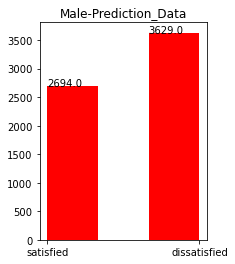

In [59]:
plt.figure(figsize=(3,4))
h3 = plt.hist(df.prediction[df.x0_Male==1.0], color='r', bins=3)
plt.title("Male-Prediction_Data")
plt.text(h3[1][0], h3[0][0], h3[0][0])
plt.text(h3[1][-2], h3[0][-1], h3[0][-1])

<Figure size 216x288 with 0 Axes>

Text(0.5, 1.0, 'Female-Production_Data')

Text(0.0, 4322.0, '4322.0')

Text(0.6666666666666666, 2304.0, '2304.0')

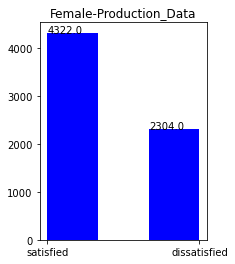

In [60]:
plt.figure(figsize=(3,4))
h2 = plt.hist(df.satisfaction[df.x0_Female==1.0], color='b', bins=3)
plt.title("Female-Production_Data")
plt.text(h2[1][0], h2[0][0], h2[0][0])
plt.text(h2[1][-2], h2[0][-1], h2[0][-1])

<Figure size 216x288 with 0 Axes>

Text(0.5, 1.0, 'Female-Prediction_Data')

Text(0.0, 4284.0, '4284.0')

Text(0.6666666666666666, 2342.0, '2342.0')

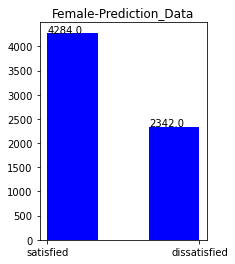

In [61]:
plt.figure(figsize=(3,4))
h4 = plt.hist(df.prediction[df.x0_Female==1.0], color='b', bins=3)
plt.title("Female-Prediction_Data")
plt.text(h4[1][0], h4[0][0], h4[0][0])
plt.text(h4[1][-2], h4[0][-1], h4[0][-1])

# Model card

In [ ]:
!pip install --upgrade pip==20.2
!pip install -U model-card-toolkit

Requirement already up-to-date: pip==20.2 in c:\users\admin\.conda\envs\mlopslab\lib\site-packages (20.2)


You should consider upgrading via the 'c:\users\admin\.conda\envs\mlopslab\python.exe -m pip install --upgrade pip' command.


^C


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\ADMIN\\.conda\\envs\\mlopslab\\Lib\\site-packages\\~yarrow\\arrow.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\admin\.conda\envs\mlopslab\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: seaborn in c:\users\admin\.conda\envs\mlopslab\lib\site-packages (0.11.2)
Requirement already up-to-date: scikit-learn in c:\users\admin\.conda\envs\mlopslab\lib\site-packages (1.0.1)
  Using cached cachetools-4.2.4-py3-none-any.whl (10 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard-2.7.0-py3-none-any.whl (5.8 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached requests_oauthlib-1

ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "c:\users\admin\.conda\envs\mlopslab\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "c:\users\admin\.conda\envs\mlopslab\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\users\admin\.conda\envs\mlopslab\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "c:\users\admin\.conda\envs\mlopslab\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above ex

In [62]:
from datetime import date
from io import BytesIO
from IPython import display
import model_card_toolkit as mctlib
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

In [63]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

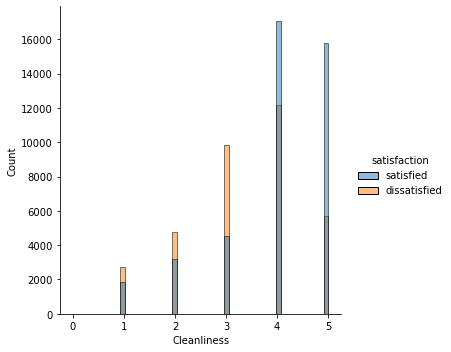

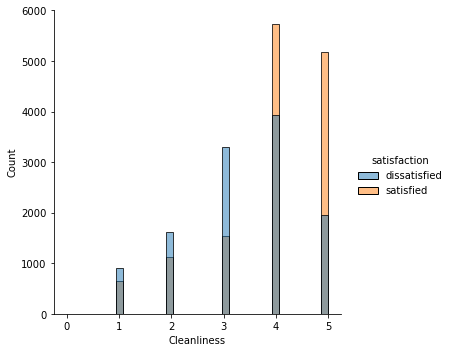

In [64]:
# Plot the mean radius feature for both the train and test sets

sns.displot(x=X_train['Cleanliness'], hue=y_train)
cleanliness_train = plot_to_str()

sns.displot(x=X_test['Cleanliness'], hue=y_test)
cleanliness_test = plot_to_str()

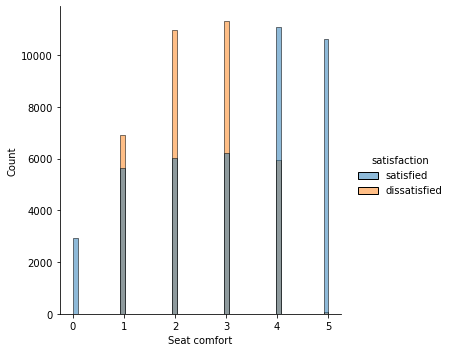

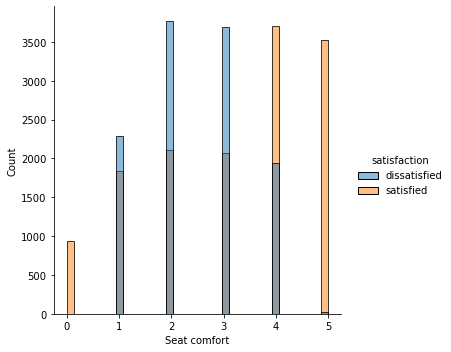

In [65]:
# Plot the mean texture feature for both the train and test sets

sns.displot(x=X_train['Seat comfort'], hue=y_train)
seat_comfort_train = plot_to_str()

sns.displot(x=X_test['Seat comfort'], hue=y_test)
seat_comfort_test = plot_to_str()

Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.


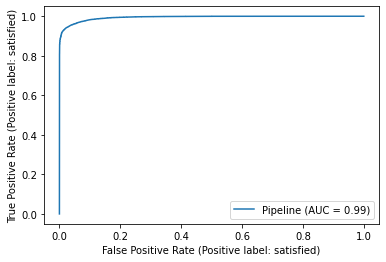

In [66]:
plot_roc_curve(xg_v1, X_test, y_test)
roc_curve = plot_to_str()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


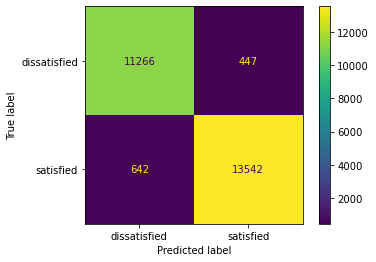

In [67]:
# Plot a confusion matrix

plot_confusion_matrix(xg_v1, X_test, y_test)
confusion_matrix = plot_to_str()

# Creating Model Card

In [68]:
mct = mctlib.ModelCardToolkit()

model_card = mct.scaffold_assets()

In [69]:
model_card.model_details.name = 'Airline Customer Satisfaction'
model_card.model_details.overview = (
    'This model predicts whether a customer is satisfied or not based on ratings and feedback given')
model_card.model_details.owners = [
    mctlib.Owner(name= 'MLOps Team 6')
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://www.kaggle.com/sjleshrac/airlines-customer-satisfaction')
]
model_card.model_details.version.name = str("Version 1.0")
model_card.model_details.version.date = str(date.today())

In [70]:
model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Method of data collection -> Feedback form may not reliable, customers might fill randomly/hastily '
            ),
    mitigation_strategy='Keep the feedback form crisp and clear by asking only for important features and make it digital'),
    mctlib.Risk(
    name=('Bias in the model and its predicitons: The model does not show signs of bias in its predictions. \
    This has been seen in the charts in the /"Understanding Bias in Model/" section of notebook 5.0 in the project repository.'
            ))]
model_card.considerations.limitations = [mctlib.Limitation(description='Model may not be applicable to other Airlines or operating in other regions')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Identify the services which has scope for improvement and Increase the customer loyalty')]
model_card.considerations.users = [mctlib.User(description='Airlines management team'), mctlib.User(description='Customer relation employees')]

In [71]:
model_card.model_parameters.data.append(mctlib.Dataset(name="Training Dataset"))
model_card.model_parameters.data[0].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=cleanliness_train),
    mctlib.Graphic(image=seat_comfort_train)
]
model_card.model_parameters.data.append(mctlib.Dataset(name="Test Dataset"))
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=cleanliness_test),
    mctlib.Graphic(image=seat_comfort_test)
]

In [72]:
model_card.quantitative_analysis.graphics.description = (
  'ROC curve and confusion matrix')
model_card.quantitative_analysis.graphics.collection = [
    mctlib.Graphic(image=roc_curve),
    mctlib.Graphic(image=confusion_matrix)
]

In [73]:
mct.update_model_card(model_card)

In [74]:
# Return the model card document as an HTML page

html = mct.export_format(output_file='../reports/airlines_modelcars_2.html')

In [75]:
display.display(display.HTML(html))

# END OF NOTEBOOK